In [1]:
import sys
sys.path.insert(0, "../../src")
from earthtext.api import osmencoderauto
from rlxutils import subplots

import numpy as np
import pandas as pd
from progressbar import progressbar as pbar

# setup

- select a folder to hold model and data, `$OSMENCODER_FOLDER`

- copy into `$OSMENCODER_FOLDER` the following files
 
    - `s3://clay-text/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt`
    - `s3://clay-text/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.yaml`
    - `s3://clay-text/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2.parquet` 
    - `s3://clay-text/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2_embeddings_v1.0_meansstdevs.pkl`
 
- check that the property `metadata_file` on the `yaml` file points to the `parquet` file


# load and initialize helper object


In [2]:
model_ckpt_fname = '/opt/data/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt'
norm_constants_fname = '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2_embeddings_v1.0_meansstdevs.pkl'
osmenc = osmencoderauto.OSMEncoderWithAutocompletion(model_ckpt_fname, norm_constants_fname)
osmenc.setup()

2024-05-21 19:52:01.959 | INFO     | earthtext.api.osmencoderauto:__init__:32 - osmencoder model is /opt/data/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt
2024-05-21 19:52:01.960 | INFO     | earthtext.api.osmencoderauto:__init__:33 - autocompletion source is 'train'
2024-05-21 19:52:01.967 | INFO     | earthtext.api.osmencoderauto:setup:51 - loading model
2024-05-21 19:52:02.029 | INFO     | earthtext.api.osmencoderauto:setup:55 - initializing dataloaders
2024-05-21 19:52:02.938 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 58690 chip files (out of 58690)
2024-05-21 19:52:02.939 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-21 19:52:03.318 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read val split with 11841 chip files (out of 11841)
2024-05-21 19:52:03.319 | INFO     | earthtext.datamodules.components.chipmultilabel:_

#### Load a checkpoint (`temp.ckpt`) whose yaml does not normalize the embeddings. This will be used purely for sim search.

In [3]:
from earthtext.search import search
# temp_yaml = '/opt/data/models/temp.ckpt'
temp_yaml = '/opt/data/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt'
searcher = search.OSMClayModelSearcher(temp_yaml, search_target='train')

print ("dataloader configuration\n")
for k,v in searcher.conf.dataloader.items():
    print (f"{k:25s} {v}")

2024-05-21 19:52:15.946 | INFO     | earthtext.search.search:__init__:76 - search target is 'train'


dataloader configuration

_target_                  earthtext.datamodules.chipmultilabel.ChipMultilabelModule
metadata_file             /opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2.parquet
embeddings_folder         /opt/data/california-worldcover-chips/embeddings_v1.0
chips_folder              /opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips
get_osm_strlabels         True
get_osm_ohearea           True
get_osm_ohecount          True
get_osm_ohelength         True
embeddings_normalization  True
multilabel_threshold_osm_ohecount 1
osmvector_normalization   True
batch_size                8
num_workers               10


In [4]:
searcher.setup()

2024-05-21 19:52:18.435 | INFO     | earthtext.search.search:setup:115 - loading model
2024-05-21 19:52:18.473 | INFO     | earthtext.search.search:setup:119 - initializing dataloaders
2024-05-21 19:52:18.872 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:104 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-05-21 19:52:22.043 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 58598 chip files (out of 58690)
2024-05-21 19:52:22.044 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-21 19:52:22.431 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:104 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-21 19:52:23.100 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - re

# make a query

In [5]:
min_counts, max_counts = {'sport=baseball':1 }, {'building=*': 0}
min_areas,  max_areas  = {}, {}

emb = osmenc.predict_embedding(min_counts, max_counts, min_areas, max_areas)

Text(0.5, 1.0, 'predicted embeddings')

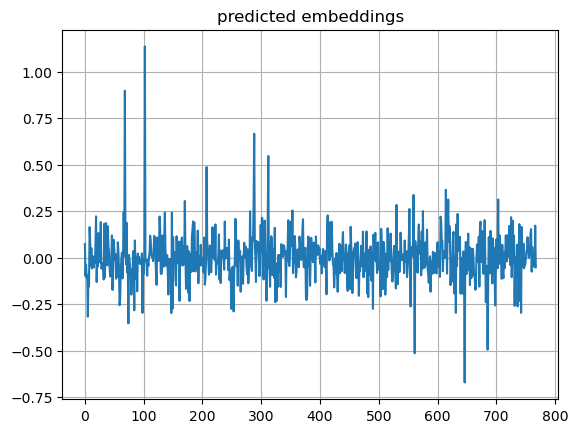

In [6]:
import matplotlib.pyplot as plt
plt.plot(emb)
plt.grid()
plt.title("predicted embeddings")

In [7]:
def get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples, query_min_counts=None, query_min_area_pct=None, n_search_samples=10, max_topn=50):

    if (query_min_area_pct is not None) + (query_min_counts is not None) != 1:
        raise ValueError(f"must set exactly one of 'query_min_area_pct' and 'query_min_counts'")
    
    chipm2 = 256*256*100 # how many square meters in a chip
    rset = []
    precs_at_topn = []

    # make user query vector
    tag_index_for_metric = np.argwhere(searcher.model.osm_tags_names==tag_name_for_metric)[0,0]
    min_counts, max_counts = {tag_name_for_metric: query_min_counts} if query_min_counts is not None else {}, {}
    min_areas,  max_areas  = {tag_name_for_metric: query_min_area_pct*chipm2} if query_min_area_pct is not None else {}  ,{}
        
    for _ in range(n_search_samples):
        
        # # average autocomplete
        # q = autocompletion_sampler.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
        #                                        min_areas = min_areas, max_areas = max_areas,
        #                                        n_samples=n_autocomplete_samples)
        
        # query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    
        # predict embeddings
        # p = searcher.predict_embeddings(query_osmvector)[0]
        p = osmenc.predict_embedding(min_counts, max_counts, min_areas, max_areas)
        
        # search
        r = searcher.make_search(p, topn=None)
        rset.append(r)
    
        # measure precision at topn, with n = 1..max_topn
        prec_at_topn = {k: (r['original_osm_vectors']['osm_ohecount'][:, searcher.model.osm_tags_indexes][:, tag_index_for_metric][:k]>1).mean()\
                        for k in range(1,max_topn+1)}
        precs_at_topn.append(prec_at_topn)
    return precs_at_topn

In [8]:
pr = {tag_name_for_metric: get_precision_at_topn(tag_name_for_metric,
                                                 n_autocomplete_samples=10,
                                                 query_min_area_pct=.01,
                                                 n_search_samples=5,
                                                 max_topn=50)
      for tag_name_for_metric in pbar(searcher.model.osm_tags_names)}

 88% (22 of 25) |#####################   | Elapsed Time: 0:01:01 ETA:   0:00:08/home/ubuntu/projects/earth-text/notebooks/api/../../src/earthtext/api/osmencoderauto.py:119: RuntimeWarning: Mean of empty slice.
  query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100% (25 of 25) |########################| Elapsed Time: 0:01:09 Time:  0:01:0902


In [9]:
class_prec_means = {i: pd.DataFrame(pr[i]).mean(axis=1).mean() for i in pr.keys()}
class_prec_stds  = {i: pd.DataFrame(pr[i]).mean(axis=1).std() for i in pr.keys()}

Text(0, 0.5, 'precision')

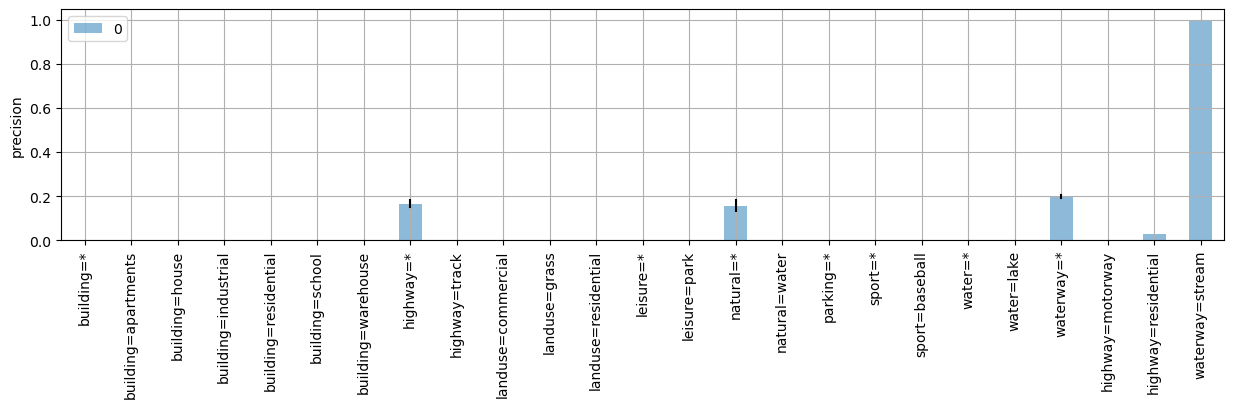

In [10]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(15,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")

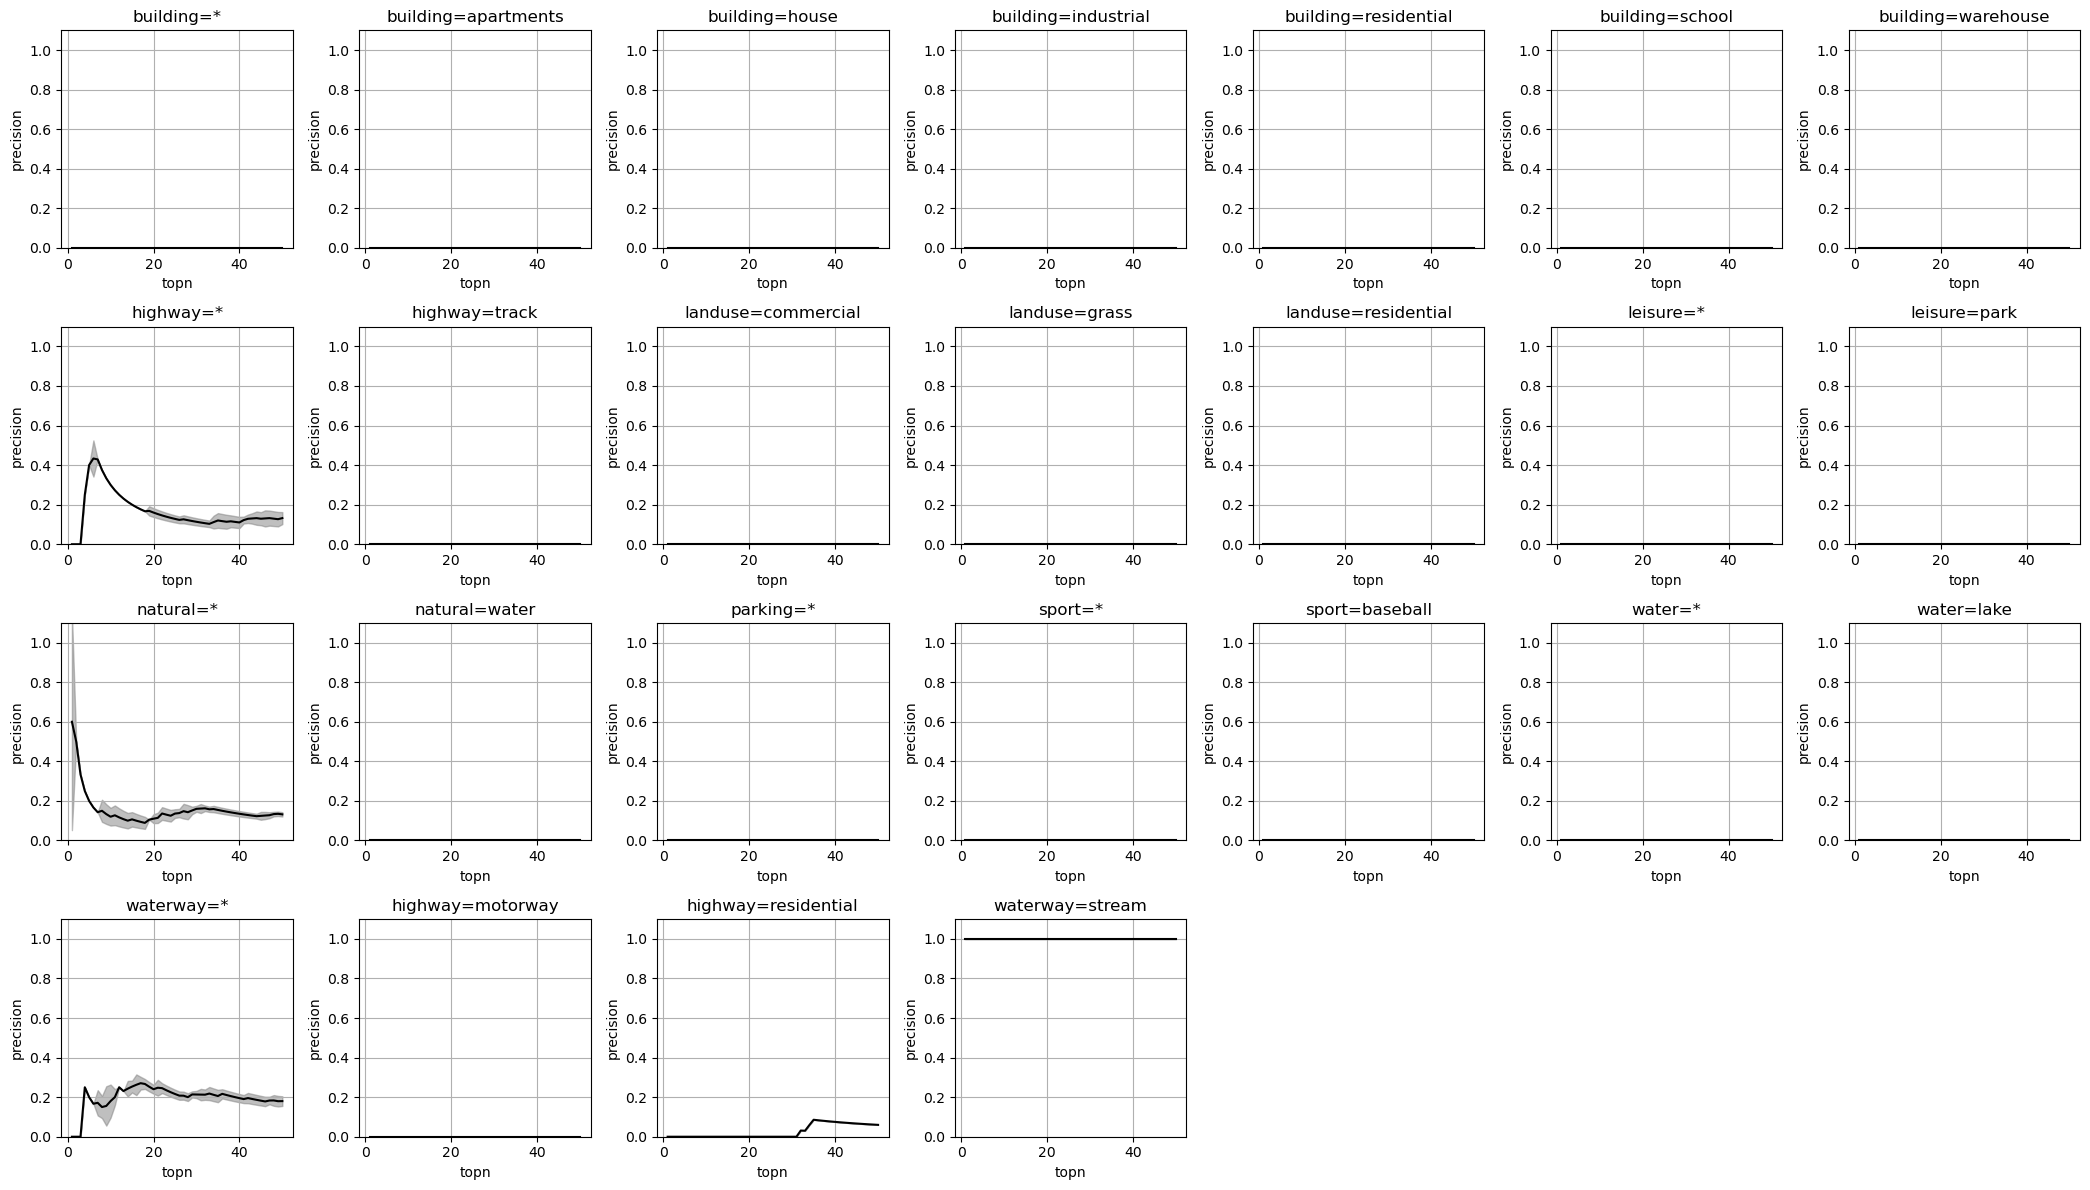

In [11]:
for ax, i in subplots(list(pr.keys()), n_cols=7):
    k = pd.DataFrame(pr[i])  
    pmeans = k.mean(axis=0).values
    pstds  = k.std(axis=0).values

    plt.plot(k.columns, pmeans, color="black")
    plt.fill_between(k.columns, pmeans-pstds, pmeans+pstds, color="gray", alpha=.5)
    plt.grid();
    plt.title(i)
    plt.ylim(0,1.1)
    plt.ylabel("precision")
    plt.xlabel("topn")